In [ ]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Import Required Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections

from scipy import stats
from datetime import datetime
from tqdm import tqdm
import itertools
import networkx as nx
import community
import seaborn as sns
import operator

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

## Load Data

In [3]:
df_av = pd.read_csv('avocado-updated-2020.csv', parse_dates=['date'])
df_av.head()

,date,average_price,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,type,year,geography
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-04,1.79,1373.95,57.42,153.88,0.00,1162.65,1162.65,0.00,0.0,organic,2015,Albany
2,2015-01-04,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.0,conventional,2015,Atlanta
3,2015-01-04,1.76,3846.69,1500.15,938.35,0.00,1408.19,1071.35,336.84,0.0,organic,2015,Atlanta
4,2015-01-04,1.08,788025.06,53987.31,552906.04,39995.03,141136.68,137146.07,3990.61,0.0,conventional,2015,Baltimore/Washington


## Exploratory Data Analysis

### Price Distribution Examination

To get us started, let us take a look at the distribution of avocado prices. We must consider three things:
1. There are two kinds of avocadoes `Conventional` and `Organic`.
2. The data contains values that are aggregates of several regions.
3. The data contains information on both time and space.

To address these issues we will do the following:
1. Filter the data for the aggregate `region` figures.
2. Disaggregate `Conventional` and `Organic` avocadoes.
3. Begin with a total price view then drill down to consider `region` and `Date` differences.

### Filter the data for the aggregated region figures
Looking at the list below we can see several regions that we should omit. Apart from the specific aggregate regions, we shall also only choose the columns that are of interest to us.

In [37]:
print(sorted(list(set(df_av['geography'].values))))

['Albany', 'Atlanta', 'Baltimore/Washington', 'Boise', 'Boston', 'Buffalo/Rochester', 'Charlotte', 'Chicago', 'Cincinnati/Dayton', 'Columbus', 'Dallas/Ft. Worth', 'Denver', 'Detroit', 'Grand Rapids', 'Harrisburg/Scranton', 'Hartford/Springfield', 'Houston', 'Indianapolis', 'Jacksonville', 'Las Vegas', 'Los Angeles', 'Louisville', 'Miami/Ft. Lauderdale', 'Nashville', 'New Orleans/Mobile', 'New York', 'Northern New England', 'Orlando', 'Philadelphia', 'Phoenix/Tucson', 'Pittsburgh', 'Portland', 'Raleigh/Greensboro', 'Richmond/Norfolk', 'Roanoke', 'Sacramento', 'San Diego', 'San Francisco', 'Seattle', 'Spokane', 'St. Louis', 'Syracuse', 'Tampa']


In [5]:
delete_list = ['Total U.S.','West','Southeast','South Central',
               'Plains','California','South Carolina',
               'Northeast','Great Lakes','Midsouth','West Tex/New Mexico']
df_av = df_av[['date','average_price','type','geography','year']]
df_av = df_av[~df_av['geography'].isin(delete_list)]
df_av.head()

,date,average_price,type,geography,year
0,2015-01-04,1.22,conventional,Albany,2015
1,2015-01-04,1.79,organic,Albany,2015
2,2015-01-04,1.00,conventional,Atlanta,2015
3,2015-01-04,1.76,organic,Atlanta,2015
4,2015-01-04,1.08,conventional,Baltimore/Washington,2015


In [6]:
df_av[df_av['year']>=2017]

,date,average_price,type,geography,year
11231,2017-01-01,1.47,conventional,Albany,2017
11232,2017-01-01,1.87,organic,Albany,2017
11233,2017-01-01,0.93,conventional,Atlanta,2017
11234,2017-01-01,1.81,organic,Atlanta,2017
11235,2017-01-01,1.47,conventional,Baltimore/Washington,2017
...,...,...,...,...,...
33034,2020-11-29,1.84,organic,St. Louis,2020
33035,2020-11-29,0.95,conventional,Syracuse,2020
33036,2020-11-29,1.46,organic,Syracuse,2020
33037,2020-11-29,0.65,conventional,Tampa,2020


### Price Examination of Conventional and Organic Avocadoes
We can see that `Conventional` avocadoes are generally less expensive than `Organic` avocadoes. Likewise, the `Conventional` avocadoes are far more concentrated around their mean. This is highlighted by the differences in their **Means**, **Medians**, **Skewness**, and level of **Standard Deviation** as seen in the below table.

This could highlight that `Conventional` avocadoes are subject to greater market competition, compelling sellers to keep their prices close to market prices. This greater adherence to market conditions can be seen quantitatively through its lower **Standard Deviation**. `Organic` avocadoes by contrast are both more expensive and have a much more diverse range of values. This can be attributed to the greater product differentiation `Organic` avocadoes have. Additionally, the buyers of `Organic` avocadoes may also be willing to accept a greater variety of prices depending on the conditions the avocadoe was grown in.

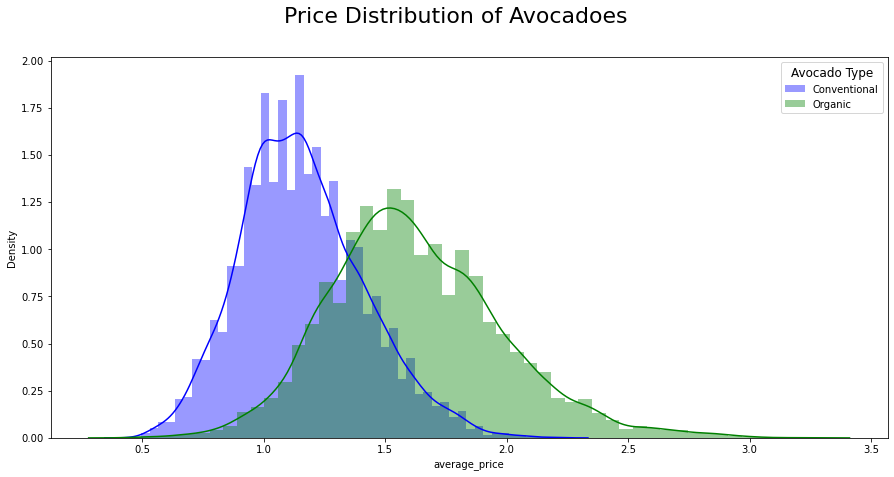

In [7]:
fig, ax = plt.subplots(figsize=(15,7))
fig.suptitle('Price Distribution of Avocadoes', fontsize = 22)
ax1 = sns.distplot(df_av[df_av['type']=='conventional']["average_price"], 
                   color = 'b', 
                   label = 'Conventional')
ax2 = sns.distplot(df_av[df_av['type']=='organic']["average_price"], 
                   color = 'g', 
                   label = 'Organic');
plt.legend(title = 'Avocado Type', title_fontsize = 12);

In [8]:
df_conv_pr = df_av[df_av['type']=='conventional']["average_price"]
df_orgn_pr = df_av[df_av['type']=='organic']["average_price"]

pd.DataFrame([['Mean', df_conv_pr.mean(),df_orgn_pr.mean()],
              ['Median', df_conv_pr.median(),df_orgn_pr.median()],
              ['Std', df_conv_pr.std(),df_orgn_pr.std()],
              ['Skewness', df_conv_pr.skew(),df_orgn_pr.skew()]],
              columns = ['Metric','Conventional','Organic'])

,Metric,Conventional,Organic
0,Mean,1.158571,1.622716
1,Median,1.140000,1.590000
2,Std,0.254246,0.357653
3,Skewness,0.421534,0.482697


### Disaggregating the Data using Factor Plots
We also have to consider the fact that the prices affected by both the `region` and the `Date` features. To give us a better idea of the differences we can make use of Factor Plots.

Immediately we can see the vast difference between regions with a noticable difference between regions in the southern United States and their northern counterparts. Intuitively, this can be attributed to the greater cost of moving avocadoes from the south to the north. For those who are unfamiliar, **avocadoes** are primarily produced in [**California**](https://www.agmrc.org/commodities-products/fruits/avocados#:~:text=According%20to%20NASS%2C%20California%20now,followed%20by%20Florida%20and%20Hawaii.) with other varieties being sources from [**Latin America**](https://en.wikipedia.org/wiki/List_of_countries_by_avocado_production). Both centers of production lead to lower prices in the Southerwestern area of the United States.

The relationship with `Date` is less certain. However, there was a notable jump in the **2017** prices across all `regions` and affecting both `types` of avocadoes. One reason for the spike was a [notable drought in **California**](https://www.bbc.com/news/business-39768480), avocades of course being a particulary drough-sensitive crop. Furthermore, we can see that avocado prices have hit record lows in **2020**.

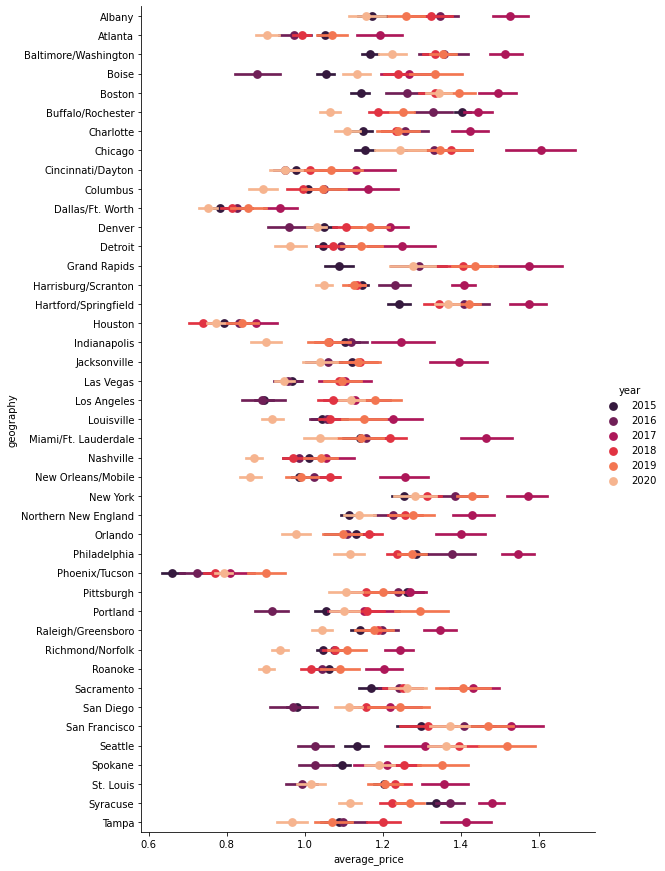

In [9]:
factor_c = sns.factorplot('average_price','geography',hue='year',
                height = 12,aspect=0.7, 
                palette='rocket', 
                join = False,
                data = df_av[df_av['type']=='conventional'],
                );

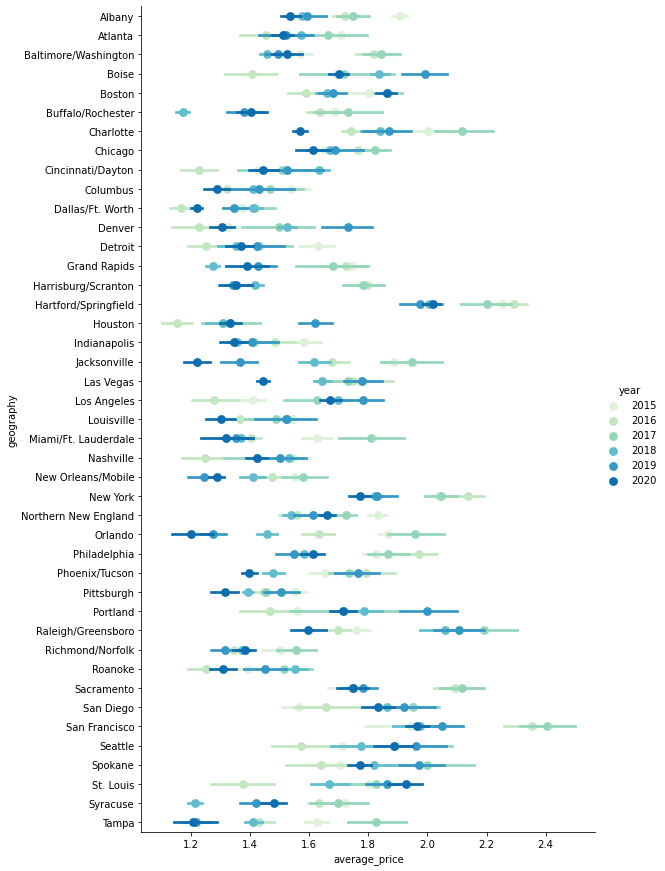

In [10]:
factor_o = sns.factorplot('average_price','geography',hue='year',
                height = 12,aspect=0.7, 
                palette='GnBu', 
                join = False,
                data = df_av[df_av['type']=='organic'],
                );

### Checking for Normality

To enable a better understanding of the underlying data, we can check for the level of normality of the data. In this case, we check if price distribution can be considered **Normally Distributed**. To do this we make use of the **Kolmogorv-Smirnov** test.

The hypothesis of the test is:<br>

**H<sub>0</sub>** : The Sample Distributions are from the same continuous distribution.

**H<sub>1</sub>**  : The Sample Distributions are **NOT** from the same continuous distribution.

By setting the **Kolmogorv-Smirnov** to `norm`, we are essentially checking whether or not the prices per `region` are normally distributed. In our case, all the prices per region are **NOT Normally Distributed**.

In [11]:
def norm_checker(df, year_thresh = 2015):
    df = df[df['year']>=year_thresh]
    final_data = []
    for r in tqdm(sorted(set(df['geography']))):
        prices_c = df.loc[(df['geography'] == r) & (df['type'] == 'conventional')]['average_price']
        prices_o = df.loc[(df['geography'] == r) & (df['type'] == 'organic')]['average_price']

        ks_statistic_c, p_value_c = stats.kstest(prices_c, 'norm')
        ks_statistic_o, p_value_o = stats.kstest(prices_o, 'norm')
        
        if p_value_c > 0.05:
            normal_c = 'normal'
        else:
            normal_c = 'not normal'
            
        if p_value_o > 0.05:
            normal_o = 'normal'
        else:
            normal_o = 'not normal' 
        
        data = [r,ks_statistic_c,p_value_c,ks_statistic_o,p_value_o, normal_c,normal_o]
        final_data.append(data)
    return pd.DataFrame(final_data, columns = ['Region', 'Kstat_conv','p_conv','Kstat_org','p_org','result_c','result_o'])
norms  = norm_checker(df_av, 2016)
norms.head()

100%|██████████| 43/43 [00:00<00:00, 94.07it/s]


,Region,Kstat_conv,p_conv,Kstat_org,p_org,result_c,result_o
0,Albany,0.814652,1.614606e-184,0.882977,6.053063e-237,not normal,not normal
1,Atlanta,0.765499,3.249778e-156,0.815397,5.416896e-185,not normal,not normal
2,Baltimore/Washington,0.838262,2.200559e-200,0.869189,1.709560e-224,not normal,not normal
3,Boise,0.727779,1.251403e-137,0.807523,4.651697e-180,not normal,not normal
4,Boston,0.832520,2.351634e-196,0.885217,4.272308e-239,not normal,not normal


## Understanding the Market

### Constructing the Linkages
To better understand the market for avocadoes, we can compare the different regions and see if we can spot similarities in their price movements. A simple way to do this is by calculating the **correlation** of each region's prices. Specifically, we make use of **Spearman's Rank Correlation** as the data was found to not be normally distributed. The code below calculates the correlation and corresponding significance for both the `conventional` and `organic` avocadoes.

In [12]:
def corr_creator_spearman(df, year_thresh = 2015):
    df = df[df['year']>=year_thresh]
    all_regions = sorted(set(df['geography']))
    region_combos = list(itertools.combinations(all_regions, 2))
    final_data_c = []
    final_data_o = []
    for c in tqdm(region_combos):
        
        df.loc[(df['geography'] == c[0]) & (df['type'] == 'organic')][['date','average_price']]
        df.loc[(df['geography'] == c[1]) & (df['type'] == 'organic')][['date','average_price']]
        merged_c = pd.merge(df.loc[(df['geography'] == c[0]) & (df['type'] == 'conventional')][['date','average_price']],
                               df.loc[(df['geography'] == c[1]) & (df['type'] == 'conventional')][['date','average_price']],
                               on='date')
        
        merged_o = pd.merge(df.loc[(df['geography'] == c[0]) & (df['type'] == 'organic')][['date','average_price']],
                            df.loc[(df['geography'] == c[1]) & (df['type'] == 'organic')][['date','average_price']],
                            on='date')

        spearmanr_c = stats.spearmanr(merged_c['average_price_x'],
                                      merged_c['average_price_y'])
        
        spearmanr_o = stats.spearmanr(merged_o['average_price_x'],
                                      merged_o['average_price_y'])
        

        c_data = [c[0],c[1], round(spearmanr_c[0],6),round(spearmanr_c[1],6)]
        o_data = [c[0],c[1], round(spearmanr_o[0],6),round(spearmanr_c[1],6) ]
        
        final_data_c.append(c_data)
        final_data_o.append(o_data)
        
    df_c = pd.DataFrame(final_data_c, columns = ['region_1','region_2','spearman_corr','significance'])
    df_o = pd.DataFrame(final_data_o, columns = ['region_1','region_2','spearman_corr','significance'])
    return [df_c,df_o]

df_spear = corr_creator_spearman(df_av, 2016)
df_spear

100%|██████████| 903/903 [00:35<00:00, 25.15it/s]


[      region_1              region_2  spearman_corr  significance
 0       Albany               Atlanta       0.486023      0.000000
 1       Albany  Baltimore/Washington       0.545374      0.000000
 2       Albany                 Boise       0.285943      0.000004
 3       Albany                Boston       0.524562      0.000000
 4       Albany     Buffalo/Rochester       0.568242      0.000000
 ..         ...                   ...            ...           ...
 898    Spokane              Syracuse       0.085856      0.172538
 899    Spokane                 Tampa       0.379024      0.000000
 900  St. Louis              Syracuse       0.417666      0.000000
 901  St. Louis                 Tampa       0.676333      0.000000
 902   Syracuse                 Tampa       0.576585      0.000000
 
 [903 rows x 4 columns],
       region_1              region_2  spearman_corr  significance
 0       Albany               Atlanta       0.074480      0.000000
 1       Albany  Baltimore/Washingt

In [13]:
def construct_network_spear(df, signthresh = 0.05, corrthresh = 0.50):
    av_G = nx.Graph()
    for i in tqdm(df.iterrows()):
        if i[1][3] <= signthresh:
            av_G.add_edge(i[1][0], i[1][1], weight = i[1][2])
        else:
            av_G.add_node(i[1][0])
            av_G.add_node(i[1][1])
    
    av_G.remove_edges_from(nx.selfloop_edges(av_G))
    low_weight_edges = [i[:2]  for i in av_G.edges(data=True) if abs(i[2]['weight']) <= corrthresh]
    av_G.remove_edges_from(low_weight_edges)
            
    return av_G

In [14]:
def get_network_metrics(df):
    
    thresh_list = np.arange(0.1,1,0.05)
    list_of_graphs = [construct_network_spear(df, 0.05, thresh) for thresh in thresh_list]

    final_list = []
    for n, g in enumerate(list_of_graphs):
        GC_nodes = max(nx.connected_components(g), key=len)
        GC = g.subgraph(GC_nodes).copy()
        SC = [g.subgraph(i).copy() for i in 
              list(nx.connected_components(g)) if i != GC_nodes]
        L = g.size() 
        avg_deg = float(L) / g.order()  
        
        #Try/Except logic as the function will error if SC == 0
        try:
            SC_average_nodes = np.mean([len(i) for i in SC])
            SC_max_nodes = np.max([len(i) for i in SC])
            SC_min_nodes = np.min([len(i) for i in SC])
        except:
            SC_average_nodes = np.nan
            SC_max_nodes = np.nan
            SC_min_nodes = np.nan
        
        data_point = (L, avg_deg, len(GC), len(SC), 
                      SC_average_nodes, SC_max_nodes, SC_min_nodes, thresh_list[n])
        final_list.append(data_point)
    return pd.DataFrame(final_list,
                        columns =  ['Size','Ave Degree',
                                    '# of Nodes in GC','# of SC', 'Mean of SCs',
                                    'Max of SCs', 'Min of SCs', 'Corr Thresh'])

df_spear_c_metrics = get_network_metrics(df_spear[0])
df_spear_o_metrics = get_network_metrics(df_spear[1])

903it [00:00, 8668.81it/s]
903it [00:00, 8694.50it/s]
903it [00:00, 8746.69it/s]
903it [00:00, 8665.50it/s]
903it [00:00, 8627.25it/s]
903it [00:00, 8765.43it/s]
903it [00:00, 8332.58it/s]
903it [00:00, 8439.49it/s]
903it [00:00, 4266.47it/s]
903it [00:00, 8715.53it/s]
903it [00:00, 8573.19it/s]
903it [00:00, 8460.13it/s]
903it [00:00, 8630.77it/s]
903it [00:00, 8714.41it/s]
903it [00:00, 8451.24it/s]
903it [00:00, 8489.03it/s]
903it [00:00, 8439.51it/s]
903it [00:00, 8674.25it/s]
903it [00:00, 8683.34it/s]
903it [00:00, 8708.10it/s]
903it [00:00, 8429.03it/s]
903it [00:00, 8565.75it/s]
903it [00:00, 7749.72it/s]
903it [00:00, 8194.09it/s]
903it [00:00, 8345.14it/s]
903it [00:00, 8521.29it/s]
903it [00:00, 8611.79it/s]
903it [00:00, 8723.96it/s]
903it [00:00, 7896.57it/s]
903it [00:00, 8245.20it/s]
903it [00:00, 8437.29it/s]
903it [00:00, 8670.40it/s]
903it [00:00, 8769.01it/s]
903it [00:00, 8466.16it/s]
903it [00:00, 8647.06it/s]
903it [00:00, 8339.02it/s]


### Choosing Threshold Metric
The next task is the selection of correlation that we should use to create linkages. Admittedly, the methodology for this is more analytical than theoretical. In choosing the appropriate threshold we have to consider the following:
1. Networks where nodes exhibiit **low correlation** may not be useful to analysts.
2. Networks where there is a **highly atomized** are also not useful.
3. Large networks are **computationally expensive** to run tests and simulations on.

The below tables show us that the behaviour of the `Conventional` avocado network seems very different from the `Organic` network. This highlight that the difference between the two markets runs deeper than the cost of production and consumer's willingness to pay. On a larger scale, the correlations between regional markets are quite different. Practically speaking, it would be wise to choose the **highest correlation** that still yields a large **Giant Component (the largest portion of the network)**.

For the `Conventional` market it seems that this figure is **0.70** while for the `Organic` market it is **0.50**. We shall continue the analysis using those specific threshold figures.

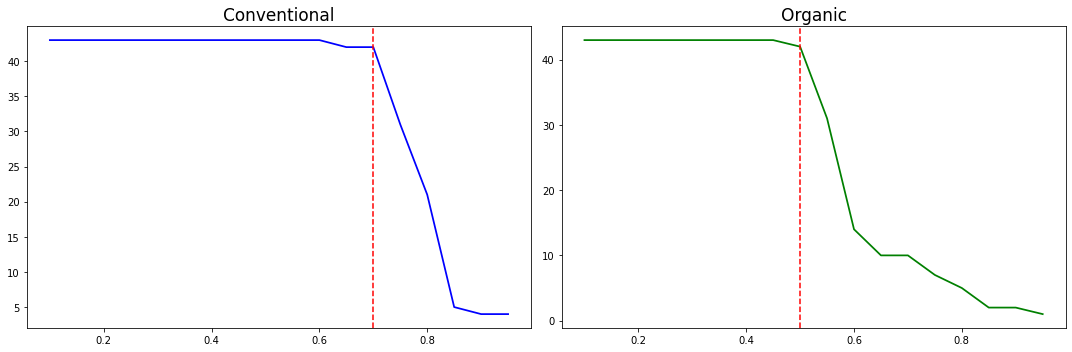

In [15]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].set_title('Conventional', fontsize = 17)
ax[0].plot(df_spear_c_metrics['Corr Thresh'],
           df_spear_c_metrics['# of Nodes in GC'],
           color = 'blue', linewidth = 1.75)
ax[0].axvline(x=0.70, color='r', linestyle='--')

ax[1].set_title('Organic', fontsize = 17)
ax[1].plot(df_spear_o_metrics['Corr Thresh'],
           df_spear_o_metrics['# of Nodes in GC'],
           color = 'green', linewidth = 1.75)
ax[1].axvline(x=0.50, color='r', linestyle='--')
fig.tight_layout();

In [16]:
df_spear_c_metrics

,Size,Ave Degree,# of Nodes in GC,# of SC,Mean of SCs,Max of SCs,Min of SCs,Corr Thresh
0,893,20.767442,43,0,NaN,NaN,NaN,0.10
1,889,20.674419,43,0,NaN,NaN,NaN,0.15
2,879,20.441860,43,0,NaN,NaN,NaN,0.20
3,873,20.302326,43,0,NaN,NaN,NaN,0.25
4,861,20.023256,43,0,NaN,NaN,NaN,0.30
5,847,19.697674,43,0,NaN,NaN,NaN,0.35
6,822,19.116279,43,0,NaN,NaN,NaN,0.40
7,767,17.837209,43,0,NaN,NaN,NaN,0.45
8,694,16.139535,43,0,NaN,NaN,NaN,0.50
9,616,14.325581,43,0,NaN,NaN,NaN,0.55


In [17]:
df_spear_o_metrics

,Size,Ave Degree,# of Nodes in GC,# of SC,Mean of SCs,Max of SCs,Min of SCs,Corr Thresh
0,715,16.627907,43,0,NaN,NaN,NaN,0.10
1,628,14.604651,43,0,NaN,NaN,NaN,0.15
2,544,12.651163,43,0,NaN,NaN,NaN,0.20
3,467,10.860465,43,0,NaN,NaN,NaN,0.25
4,377,8.767442,43,0,NaN,NaN,NaN,0.30
5,303,7.046512,43,0,NaN,NaN,NaN,0.35
6,244,5.674419,43,0,NaN,NaN,NaN,0.40
7,193,4.488372,43,0,NaN,NaN,NaN,0.45
8,150,3.488372,42,1,1.000000,1.0,1.0,0.50
9,109,2.534884,31,3,4.000000,9.0,1.0,0.55


In [18]:
### Create the Spearman Correlation DataFrames
spear_c_network = construct_network_spear(df_spear[0], 0.05, 0.70)
spear_o_network = construct_network_spear(df_spear[1], 0.05, 0.50)

903it [00:00, 8545.82it/s]
903it [00:00, 8701.42it/s]


In [19]:
def plot_single_network(network, title):
    plt.figure(figsize=(15,7)) 
    
    g_corr = network.subgraph(sorted(nx.connected_components(network), key = len, reverse = True)[0])
    d = dict(network.degree)
    d_g = dict(g_corr.degree)
    plt.suptitle(title, fontsize=20, y=0.95)
    pos = nx.spring_layout(network, seed = 45);
    nx.draw_networkx_nodes(network , pos, cmap=plt.cm.RdYlBu_r,
                           node_color = [val for (node, val) in network.degree()],
                           node_size=[v * 25 for v in d.values()]);
    nx.draw_networkx_edges(network , pos, width=0.75, alpha=0.45, 
                            edge_color="grey");
    nx.draw_networkx_labels(network, pos, font_color  = 'grey')
    plt.show();
    
    plt.figure(figsize=(15,7)) 
    plt.suptitle(f'{title} Giant Component', fontsize=20, y=0.95)
    pos = nx.spring_layout(g_corr, seed = 45);
    nx.draw_networkx_nodes(g_corr , pos, cmap=plt.cm.RdYlBu_r,
                           node_color = [val for (node, val) in g_corr.degree()],
                           node_size=[v * 25 for v in d_g.values()]);
    nx.draw_networkx_edges(g_corr , pos, width=0.75, alpha=0.45, 
                            edge_color="grey");
    nx.draw_networkx_labels(g_corr, pos, font_color  = 'grey')
    
    plt.show();
    
def degree_dist(network1, network2):
    degrees1 = [d for n,d in network1.degree()]
    degrees2 = [d for n,d in network2.degree()]
    
    fig, ax = plt.subplots(figsize=(15,7))
    fig.suptitle('Degree Distribution of Networks', fontsize = 22)
    ax1 = sns.histplot(degrees1, edgecolor='white', linewidth=0.75,
                       color = 'b', kde = False, binwidth=1,alpha = 0.55,
                       label = 'Conventional')
    ax2 = sns.histplot(degrees2, edgecolor='white', linewidth=0.75,
                       color = 'g', kde = False, binwidth=1,alpha = 0.55,
                       label = 'Organic');
    plt.legend(title = 'Degree Distribution', title_fontsize = 12);

### Network Analysis
Examining the networks, we can see the vast difference between the `Conventional` and `Organic` markets. The `Conventional` markets being far more closely linked, evidenced by their high degree of connectivity despite their higher correlation threshold. `Organic` markets are far more diverse, almost splitting apart at even their lower threshold. 

Looking into the degree distribution, we find that the two networks have extremely different underlying structures. In the `Conventional` market we see that the central nodes dominate when it comes to degree of connections. The `Organic` market on the other hand has a much more distributed level of degrees. This implies that prices tend to be stickier in the `Conventional` and far more reactive in the `Organic`. 

In [20]:
def plot_single_network(network, title):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    
    g_corr = network.subgraph(sorted(nx.connected_components(network), key = len, reverse = True)[0])
    d = dict(network.degree)
    d_g = dict(g_corr.degree)
    ax[0].set_title(title, fontsize=20, y=1.0)
    pos = nx.spring_layout(network, seed = 45)
    nx.draw_networkx_nodes(network , pos, cmap=plt.cm.RdYlBu_r,
                           node_color = [val for (node, val) in network.degree()],
                           node_size=[v * 25 for v in d.values()], 
                           ax = ax[0]);
    nx.draw_networkx_edges(network , pos, width=0.75, alpha=0.45, 
                            edge_color="grey", ax = ax[0]);
    nx.draw_networkx_labels(network, pos, font_color  = 'grey', 
                            ax = ax[0])
    
    ax[1].set_title(f'{title} Giant Component', fontsize=20, y=1.0)
    pos = nx.spring_layout(g_corr, seed = 45);
    nx.draw_networkx_nodes(g_corr , pos, cmap=plt.cm.RdYlBu_r,
                           node_color = [val for (node, val) in g_corr.degree()],
                           node_size=[v * 25 for v in d_g.values()],
                           ax = ax[1]);
    nx.draw_networkx_edges(g_corr , pos, width=0.75, alpha=0.45, 
                            edge_color="grey",ax = ax[1]);
    nx.draw_networkx_labels(g_corr, pos, font_color  = 'grey',
                            ax = ax[1])
    
    fig.tight_layout();

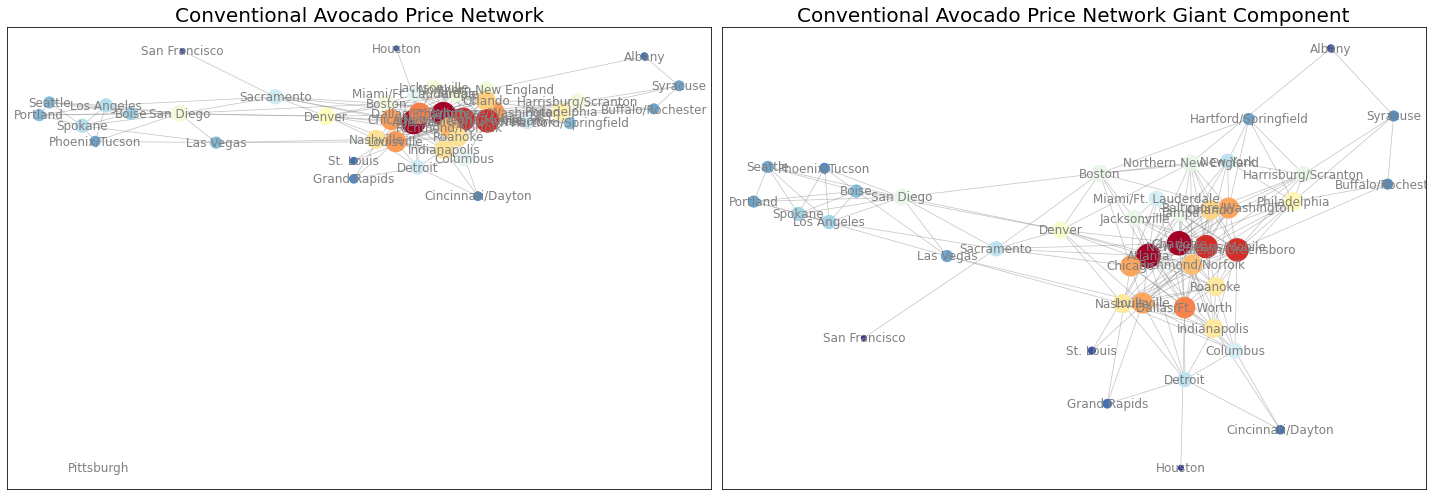

In [21]:
plot_single_network(spear_c_network, 'Conventional Avocado Price Network')

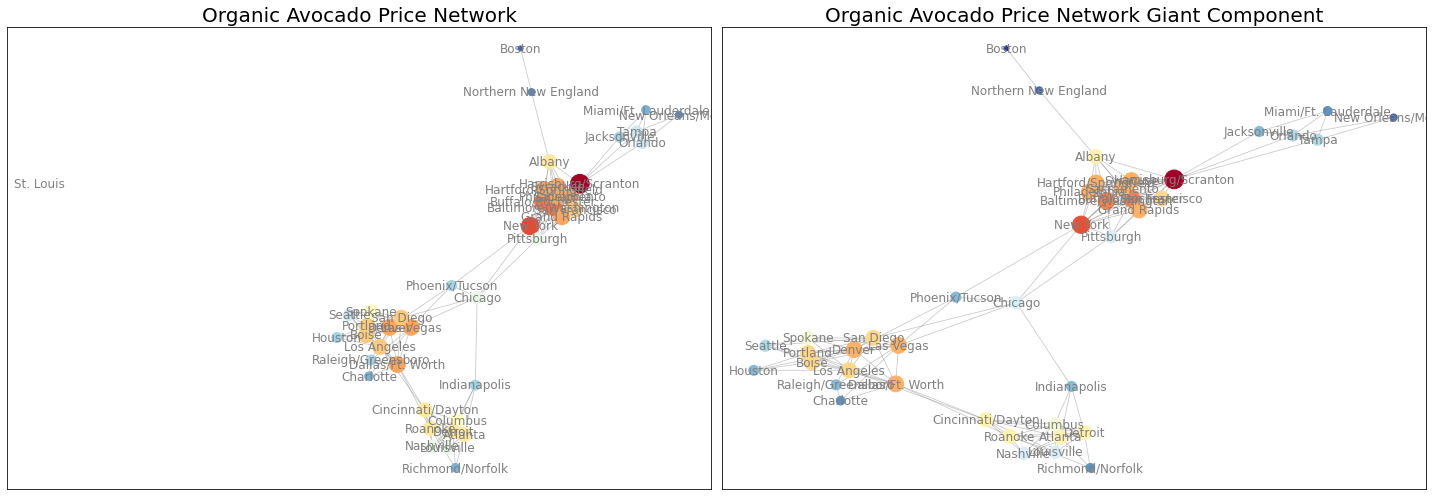

In [22]:
plot_single_network(spear_o_network, 'Organic Avocado Price Network')

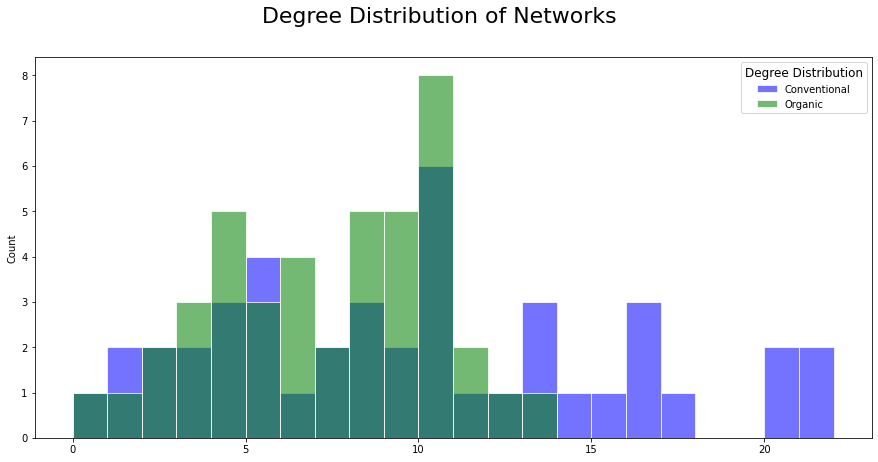

In [23]:
degree_dist(spear_c_network,spear_o_network)

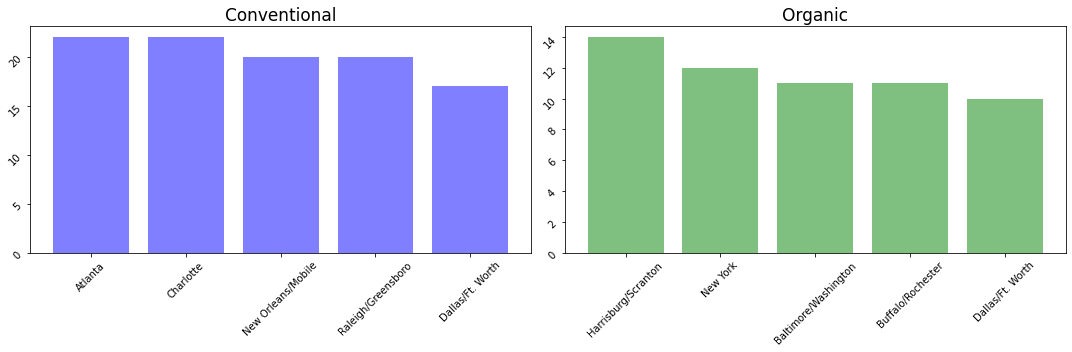

In [24]:
### Get top 5 nodes with the most degrees
deg_c = sorted([(n,d) for n,d in spear_c_network.degree()], key = lambda x:(-x[1], x[0]))[:5]
deg_o = sorted([(n,d) for n,d in spear_o_network.degree()], key = lambda x:(-x[1], x[0]))[:5]

### Plot the distribution
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].set_title('Conventional', fontsize = 17)
ax[0].bar(range(len(deg_c)), 
          [val[1] for val in deg_c],
          color = 'blue', 
          alpha = 0.50,
          align='center')
ax[0].set_xticks(range(len(deg_c)))
ax[0].set_xticklabels([val[0] for val in deg_c])
ax[0].tick_params(rotation=45)

ax[1].set_title('Organic', fontsize = 17)
ax[1].bar(range(len(deg_o)), 
          [val[1] for val in deg_o],
          color = 'green', 
          alpha = 0.50,
          align='center')
ax[1].set_xticks(range(len(deg_o)))
ax[1].set_xticklabels([val[0] for val in deg_o])
ax[1].tick_params(rotation=45)

fig.tight_layout()

### Measuring Interconnectivity

The interconnectivity of the graph helps us improve our understanding of the its dynamics. To a lesser extent we get an idea through the **Average Degree** and **Nodes in the Giant Component** metrics, however such measures are quite rough and may not always give the full picutre. Below are two measurements we shall focus on:<br>

**Clustering Coefficient** - The level of interconnectivity a system has based on the level of connectiviy of each node.<br>
**Rich Club Coefficient** - The level of interconnectivity of the nodes with the most connections with each other. <br>

For the **Clustering Coefficient**, we can see that the `Conventional` market has a notable decline after the most highly connected nodes. The `Organic` market takes much longer to drop off. This highlights the difference in connectivity level hinted at when visually examining the graph. 

The **Rich Club Coefficient** tells quite an interesting story. The `Conventional` market shows a a coefficient that consistently grows and then shoots up and plateaus at degrees greater than 10. The `Organic` market shows a much slower increase over the number of degrees; however, it exhibits a massive jump also at degrees greater than 10. This highlights the centralized nature of the `Conventional` market, with a regions connectivity with other regions growing consistently as it gains more connections. The decentralized nature of the `Organic` market means that even though a region increases its connectivity with other nodes will not guarantee it suddenly "joins the club". It seems that it must connect with a specific hub to gain the benefits.

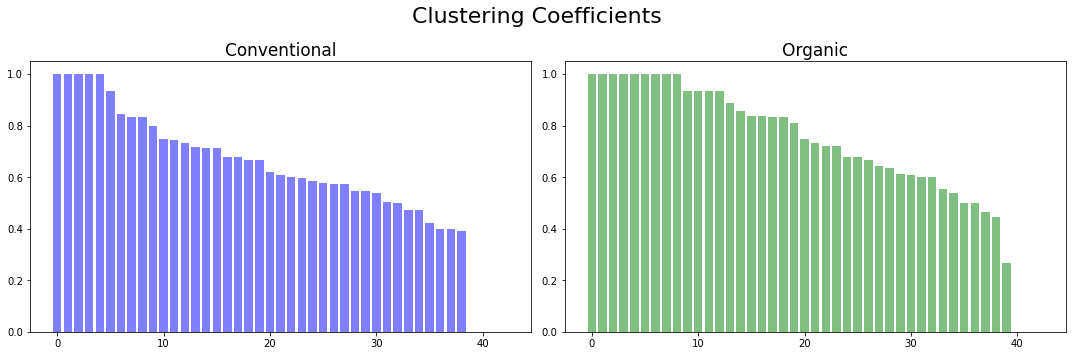

In [25]:
### Get the Clustering Coefficiencts of the Graph
cc_c = sorted(nx.clustering(spear_c_network).items(), key = lambda x:(-x[1],x[0]))
cc_o = sorted(nx.clustering(spear_o_network).items(), key = lambda x:(-x[1],x[0]))

### Plot the distribution
fig, ax = plt.subplots(1,2,figsize=(15,5))
fig.suptitle('Clustering Coefficients', fontsize=22)
ax[0].set_title('Conventional', fontsize = 17)
ax[0].bar(range(len(cc_c)), 
          [val[1] for val in cc_c],
          color = 'blue', 
          alpha = 0.50,
          align='center')

ax[1].set_title('Organic', fontsize = 17)
ax[1].bar(range(len(cc_o)), 
          [val[1] for val in cc_o],
          color = 'green', 
          alpha = 0.50,
          align='center')

fig.tight_layout();

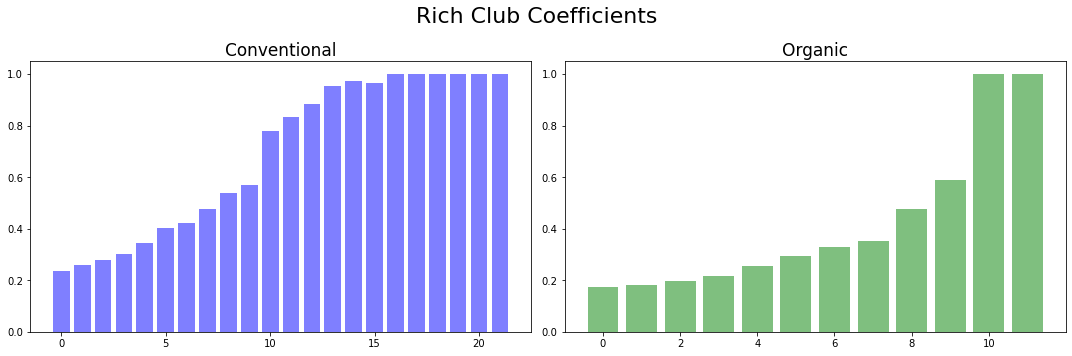

In [26]:
### Get the Rich Club Coefficiencts of the Graph
rc_c = nx.rich_club_coefficient(spear_c_network, normalized=False, seed=42)
rc_o = nx.rich_club_coefficient(spear_o_network, normalized=False, seed=42)

### Plot the distribution
fig, ax = plt.subplots(1,2,figsize=(15,5))
fig.suptitle('Rich Club Coefficients', fontsize=22)
ax[0].set_title('Conventional', fontsize = 17)
ax[0].bar(rc_c.keys(),
          rc_c.values(),
          color = 'blue', 
          alpha = 0.50,
          align='center')

ax[1].set_title('Organic', fontsize = 17)
ax[1].bar(rc_o.keys(), 
          rc_o.values(),
          color = 'green', 
          alpha = 0.50,
          align='center')

fig.tight_layout();

In [27]:
def centrality_plotter(network, title):
    g_corr = network.subgraph(sorted(nx.connected_components(network), key = len, reverse = True)[0])
    fig, ax = plt.subplots(2,2, figsize=(20,15))
    
    centralities = [list(nx.degree_centrality(g_corr).values()), 
                    list(nx.closeness_centrality(g_corr).values()), 
                    list(nx.betweenness_centrality(g_corr).values()),
                    list(nx.eigenvector_centrality(g_corr).values())]
    titles = ['Degree Centrality', 'Closeness Centrality', 
              'Betweenness Centrality', 'Eigenvector Centrality']
    fig.suptitle(title, fontsize=25)
    for n, ax in enumerate(ax.flatten()):
        ax.set_title(titles[n], fontsize = 19);
        pos = nx.spring_layout(g_corr, seed = 45)
        
        nc = nx.draw_networkx_nodes(g_corr, pos, node_size=300, cmap=plt.cm.RdYlBu_r,
                                    node_color=centralities[n], ax = ax);
        
        
        nx.draw_networkx_edges(g_corr, pos, alpha=0.40, ax = ax);
        nx.draw_networkx_labels(g_corr, pos, font_color='grey', ax = ax);
        ax.set_axis_off()
        plt.colorbar(nc, ax = ax);

    fig.tight_layout()
    fig.subplots_adjust(top=0.90);

### Centrality Measurements
To better understand the structure of the network, we can look into the four primary centrality measurements. <br>
1. **Degree Centrality** - based on **number of direct connections** a node has.
2. **Closeness Centrality** - based on **how short the shortest paths** a node has.
3. **Betweenness Centrality** - based on **how many shortest paths pass** through node.
4. **Eigenvector Centrality** -  based on **connectedness of a node's direct neighbors**.

We can see that for the `Conventional` market, there is a high overlap in their Degree, Closeness, and Eigenvector centralities. Nodes located at the center seemingly having highest centrality values while those at the periphery have much lower values. Betweeness though is concentrated in only a few nodes, studying these nodes should then be of particular importance to market researchers. 

The `Organic` market on the other hand has noticeable overlap in its Degree and Closeness. It seems that each small group of nodes have their own highly connected network. We notice the relative unimportance of the northeastern regions, such as **Albany**, **Northern New England**, and **Boston**. This highlights that the avocado price behaviour in these regions should not be compared to avocado prices in the rest of the United States.Interestingly, we can see that the most in-between nodes sit on the opposite ends of the network. This implies that it can pay off to spend more resources understanding those two particular regions. They may be the key in understanding the behaviour of different markets. 

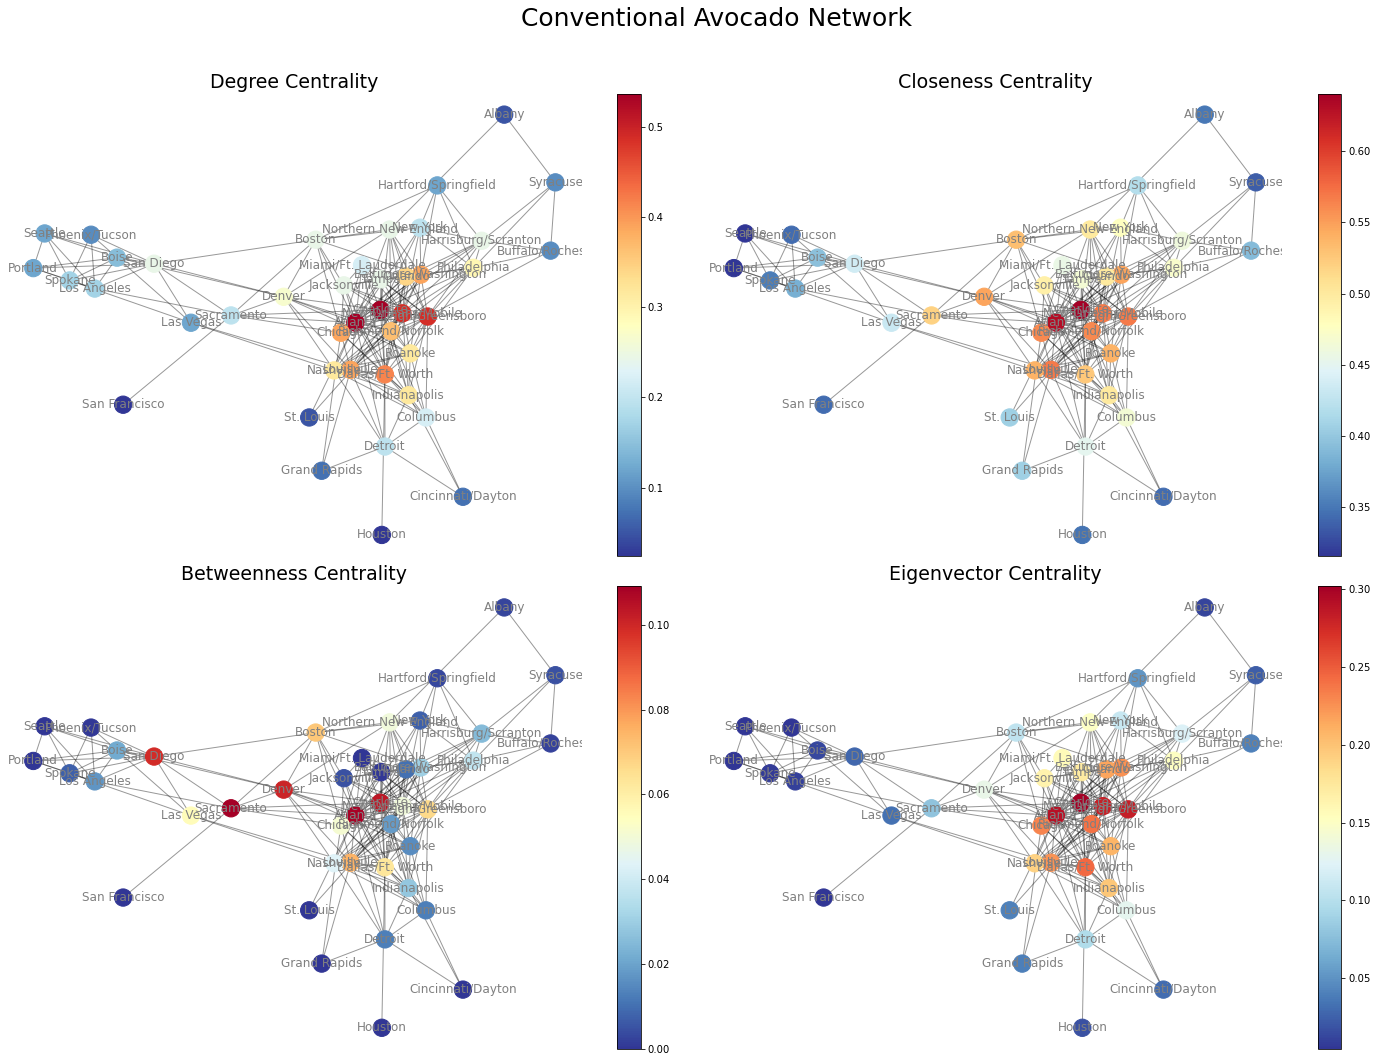

In [28]:
centrality_plotter(spear_c_network, 'Conventional Avocado Network')

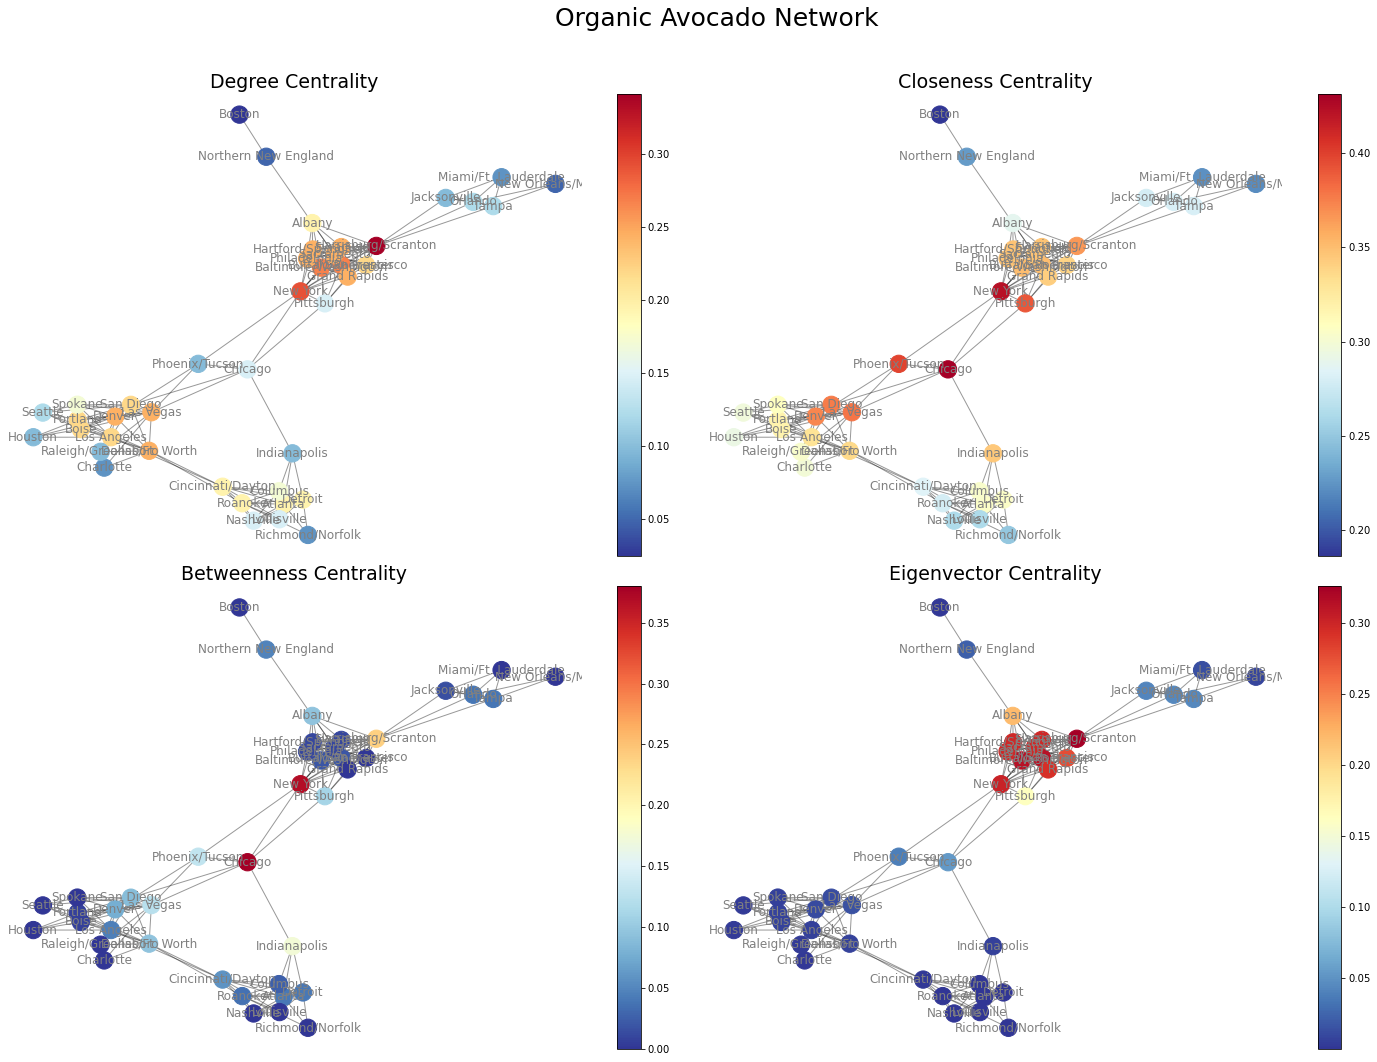

In [29]:
centrality_plotter(spear_o_network,'Organic Avocado Network')

In [30]:
def community_plotter(network1, network2):
    titles = ['Conventional Communities','Organic Communities']
    g_corr_1 = network1.subgraph(sorted(nx.connected_components(network1), key = len, reverse = True)[0])
    g_corr_2 = network2.subgraph(sorted(nx.connected_components(network2), key = len, reverse = True)[0])
    
    partition_1 = community.best_partition(g_corr_1, random_state = 42)
    partition_2 = community.best_partition(g_corr_2, random_state = 42)
    
    identifier = [list(partition_1.values()),
                  list(partition_2.values())]
    
    graphs = [g_corr_1,g_corr_2]
    
    fig, ax = plt.subplots(1,2, figsize=(15,7))
    for n, ax in enumerate(ax.flatten()):
        ax.set_title(titles[n], fontsize = 17);
        pos = nx.spring_layout(graphs[n], seed = 45)
        
        nc = nx.draw_networkx_nodes(graphs[n], pos, node_size=300, cmap=plt.cm.RdYlBu_r,
                                    node_color=identifier[n], ax = ax);
        
        nx.draw_networkx_edges(graphs[n], pos, alpha=0.40, ax = ax);
        nx.draw_networkx_labels(graphs[n], pos, font_color='grey', font_size = 9.5, ax = ax);
        
    fig.tight_layout();

### Community Detection
Finally, one of the most useful functions of a network is the construction of communities. In this case we make use of the popular **Louvain Method** which works by optimizing the modularity of the network. 

The below graphs show that the algorithm identifies 4 communities for the `Conventional` market and 5 communities for the `Organic` market. However, the exculsion of **Boston** and **New England** in the `Organic` market seems unnecessary. When selecting a framework to analyze the data it could be beneficial to include them as part of the light blue community. 

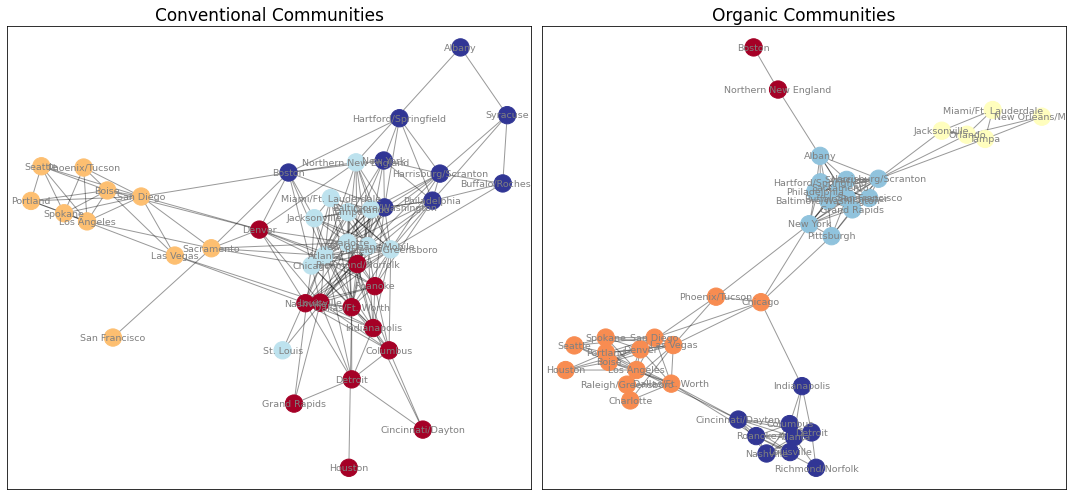

In [31]:
community_plotter(spear_c_network, spear_o_network)

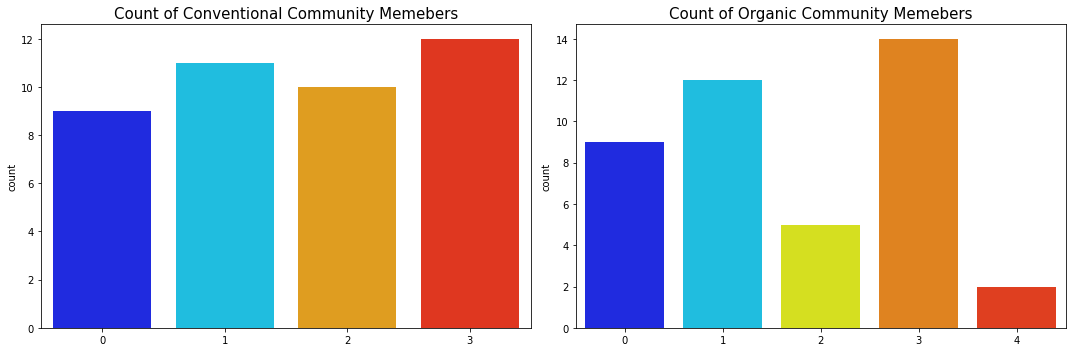

In [34]:
### Extract Giant Components
g_corr_c = spear_c_network.subgraph(sorted(nx.connected_components(spear_c_network), key = len, reverse = True)[0])
g_corr_o = spear_o_network.subgraph(sorted(nx.connected_components(spear_o_network), key = len, reverse = True)[0])

partition_c = community.best_partition(g_corr_c, random_state = 42)
partition_o = community.best_partition(g_corr_o, random_state = 42)

fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.countplot(x = 0, data = pd.DataFrame(partition_c, index = [0]).T.reset_index(), 
              ax = ax[0], palette =['#000fff', '#00D1FF','#Ffa700', '#Ff1f00'] ).set_title("Count of Conventional Community Memebers", fontsize = 15);
sns.countplot(x = 0, data = pd.DataFrame(partition_o, index = [0]).T.reset_index(), 
              ax = ax[1], palette =['#000fff', '#00D1FF','#f2ff00', '#ff8400','#Ff2900']).set_title("Count of Organic Community Memebers", fontsize = 15);
ax[0].set(xlabel=None)
ax[1].set(xlabel=None)

fig.tight_layout();

### Community Comparisons

In [36]:
partition_c

{'Albany': 0,
 'Atlanta': 1,
 'Baltimore/Washington': 0,
 'Boise': 2,
 'Boston': 0,
 'Buffalo/Rochester': 0,
 'Charlotte': 1,
 'Chicago': 1,
 'Cincinnati/Dayton': 3,
 'Columbus': 3,
 'Dallas/Ft. Worth': 3,
 'Denver': 3,
 'Detroit': 3,
 'Grand Rapids': 3,
 'Harrisburg/Scranton': 0,
 'Hartford/Springfield': 0,
 'Houston': 3,
 'Indianapolis': 3,
 'Jacksonville': 1,
 'Las Vegas': 2,
 'Los Angeles': 2,
 'Louisville': 3,
 'Miami/Ft. Lauderdale': 1,
 'Nashville': 3,
 'New Orleans/Mobile': 1,
 'New York': 0,
 'Northern New England': 1,
 'Orlando': 1,
 'Philadelphia': 0,
 'Phoenix/Tucson': 2,
 'Portland': 2,
 'Raleigh/Greensboro': 1,
 'Richmond/Norfolk': 3,
 'Roanoke': 3,
 'Sacramento': 2,
 'San Diego': 2,
 'San Francisco': 2,
 'Seattle': 2,
 'Spokane': 2,
 'St. Louis': 1,
 'Syracuse': 0,
 'Tampa': 1}

In [35]:
df_av

,date,average_price,type,geography,year
0,2015-01-04,1.22,conventional,Albany,2015
1,2015-01-04,1.79,organic,Albany,2015
2,2015-01-04,1.00,conventional,Atlanta,2015
3,2015-01-04,1.76,organic,Atlanta,2015
4,2015-01-04,1.08,conventional,Baltimore/Washington,2015
...,...,...,...,...,...
33034,2020-11-29,1.84,organic,St. Louis,2020
33035,2020-11-29,0.95,conventional,Syracuse,2020
33036,2020-11-29,1.46,organic,Syracuse,2020
33037,2020-11-29,0.65,conventional,Tampa,2020
